In [1]:
""" Layered model """
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm,trange

import ehtim as eh

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

Welcome to eht-imaging! v  1.1.1


In [2]:
# num visibility values, split into real/complex
INPUT_SIZE = 1030*2
INPUT_SHAPE = (1030, 2)

# n pixels in image
OUTPUT_SIZE = 28*28
OUTPUT_SHAPE = (28, 28)


to_display = eh.image.load_txt('../models/avery_sgra_eofn.txt');
to_display = to_display.resample_square(28)

def show_image(arr):
    """Displays image given a ndarray of pixels in shape (28,28)."""
    to_display.imvec = arr.reshape(784)
    return to_display.display()

Loading text image:  ../models/avery_sgra_eofn.txt


In [182]:
# Load clean Fashion MNIST data

x = torch.load("../data/clean/obs_0-15000.pickle")
x = torch.cat((x, torch.load("../data/clean/obs_15000-30000.pickle")))
x = torch.cat((x, torch.load("../data/clean/obs_30000-45000.pickle")))

y = torch.load("../data/clean/img_0-15000.pickle")
y = torch.cat((y, torch.load("../data/clean/img_15000-30000.pickle")))
y = torch.cat((y, torch.load("../data/clean/img_30000-45000.pickle")))

x_train = x[:44000]
y_train = y[:44000]
x_test = x[44000:]
y_test = y[44000:]

trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torch.utils.data.TensorDataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [3]:
# Load noisy Fashion MNIST data

x_train = torch.as_tensor(np.load("../data/noisy/train_inputs_old_fashion_mnist_all.npy"), 
                    dtype=torch.float)

y_train = torch.as_tensor(np.load("../data/noisy/train_outputs_fashion_mnist_all.npy"), 
                    dtype=torch.float)

x_test = torch.as_tensor(np.load("../data/noisy/train_inputs_amp_and_cphase_fashion_mnist_all.npy"), 
                    dtype=torch.float)

y_test = torch.as_tensor(np.load("../data/noisy/train_outputs_fashion_mnist_all.npy"), 
                    dtype=torch.float)

trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torch.utils.data.TensorDataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)


In [172]:
""" One neural network in the component """
class NeuralComp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # in_channels of input channels, out_channels of output channels
        self.neural_comp = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # input 56 x 56
            #nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.neural_comp(x)

class DownScale(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

In [179]:
""" Cascade Part """
class CascadeNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.dense = nn.Sequential(
            nn.Linear(2060, 56*56),
            nn.ReLU(),)
        self.loss = nn.MSELoss()
        self.nets = nn.ModuleList()
        self.apply = self.nets.append(NeuralComp(n_channels,8))
        
        self.outc = nn.Conv2d(8, 8, kernel_size=1)
        
        self.d1 = DownScale(8, 16)
        
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        x = x.view(-1,1,56,56)
        
        # number of layers in network
        for i in range(4):
            self.apply
        
        
        
        prev_inputs = [torch.FloatTensor(t) for t in x]
        for m in range(len(self.nets)):
            input = torch.stack((prev_inputs), dim=1)
            input = input.view(-1, 8, 112, 112)
            input = self.d1(input)
            x = self.nets[m](input)
            if m < len(self.nets) - 1:
                x = nn.ReLU(x)
            
            prev_inputs.append(x)
        x = self.outc(x)
        x = x.squeeze(dim=1)
        x = x.view(-1, 28, 28)
        
        return x

            

In [180]:
# Initialize model and optimizer
model = CascadeNet(8, 1, False)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50


Target


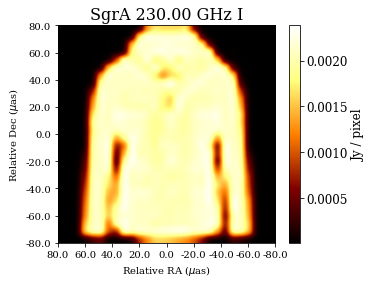

Reconstruction


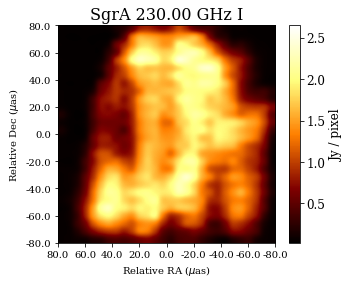

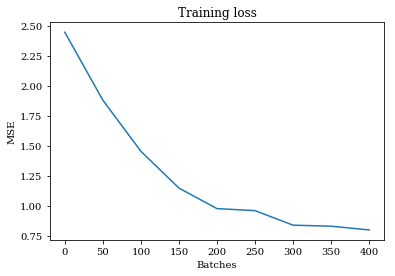


Target


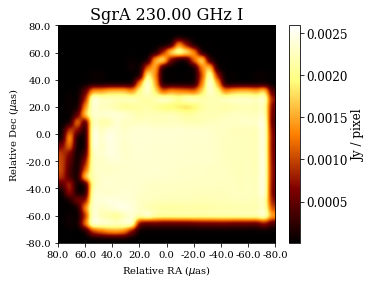

Reconstruction


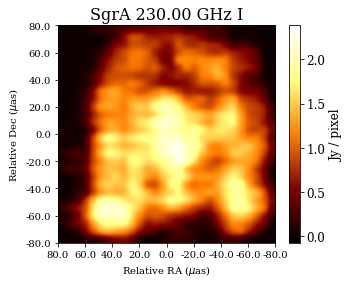

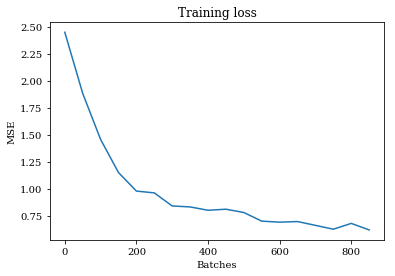


Target


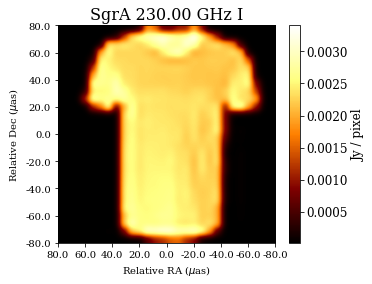

Reconstruction


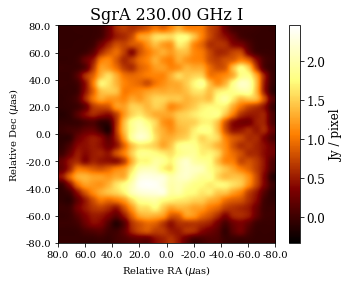

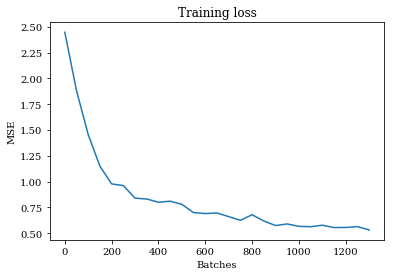


Target


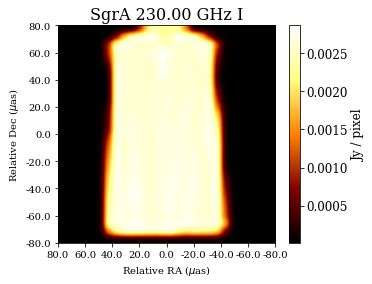

Reconstruction


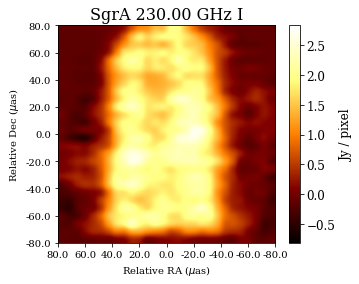

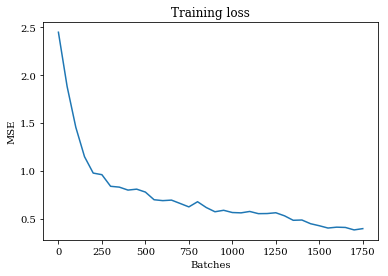


Target


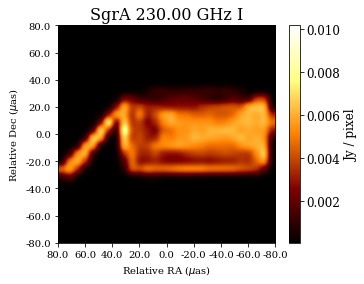

Reconstruction


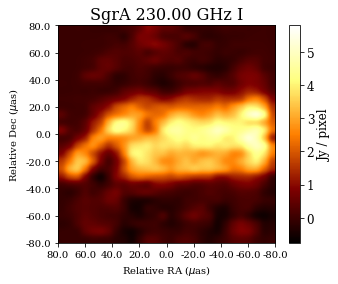

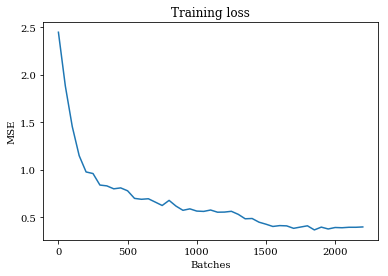


Target


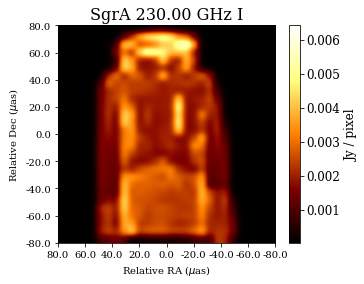

Reconstruction


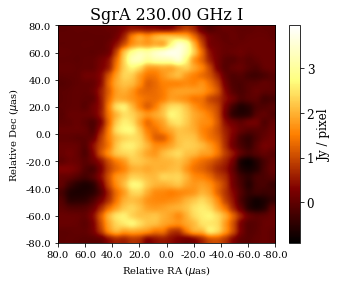

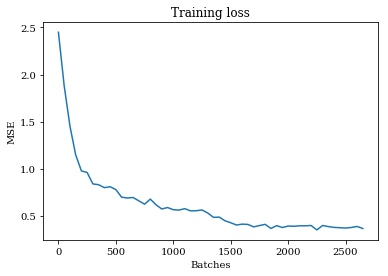


Target


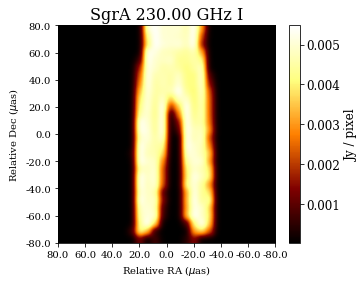

Reconstruction


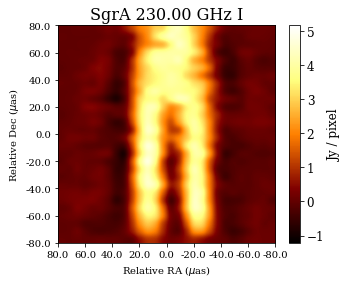

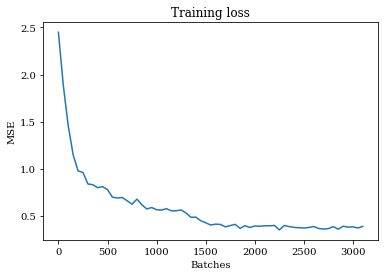


Target


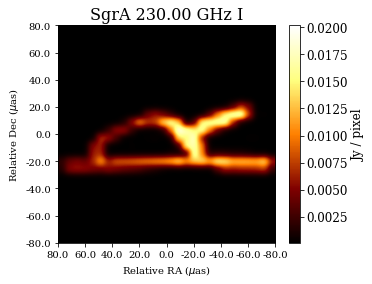

Reconstruction


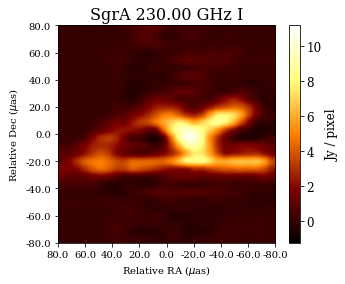

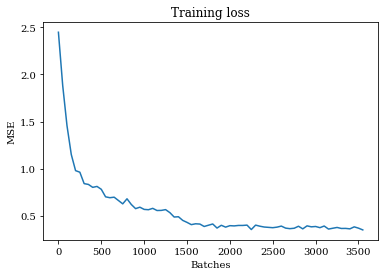


Target


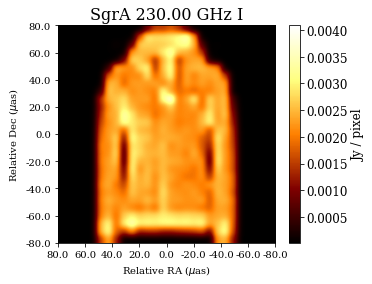

Reconstruction


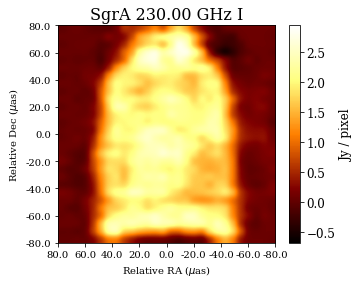

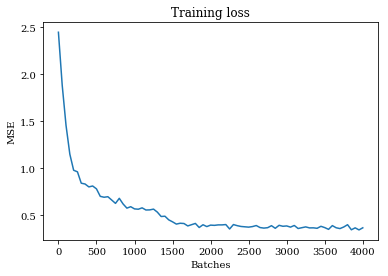


Target


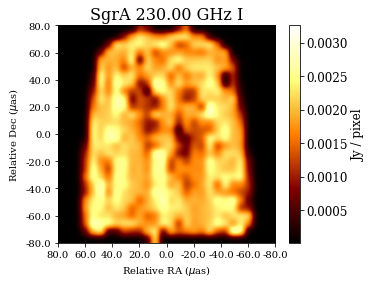

Reconstruction


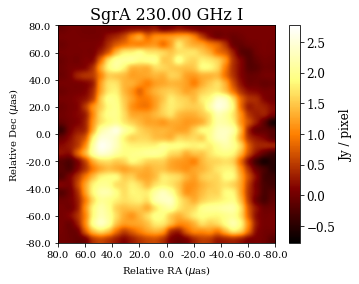

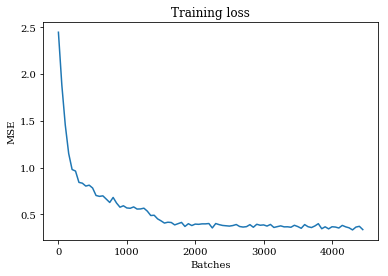


Target


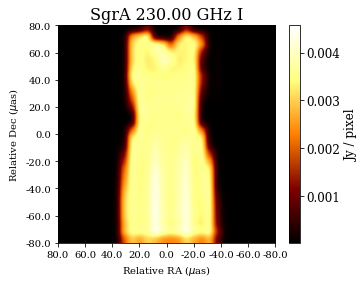

Reconstruction


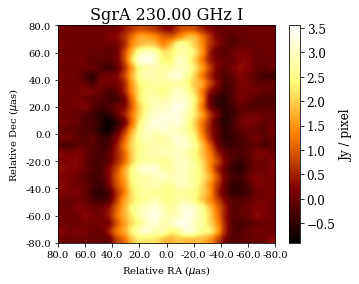

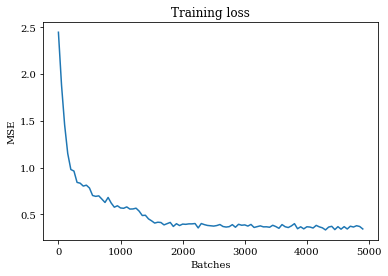


Target


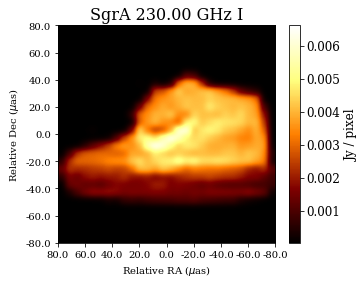

Reconstruction


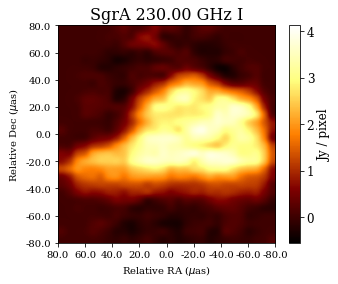

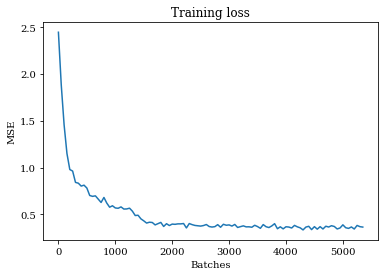


Target


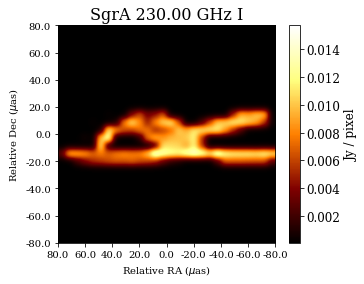

Reconstruction


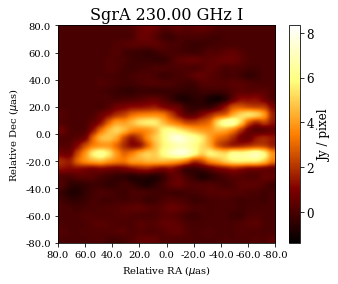

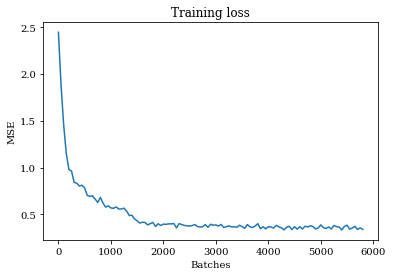


Target


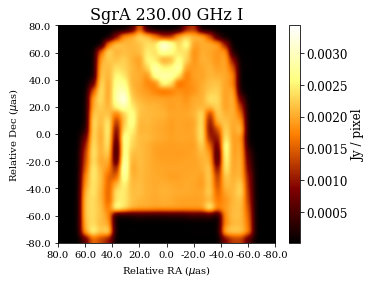

Reconstruction


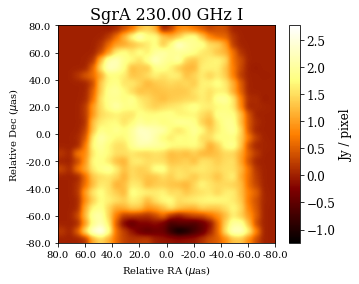

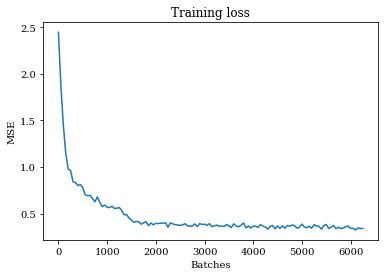


Target


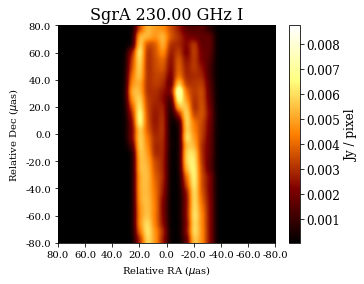

Reconstruction


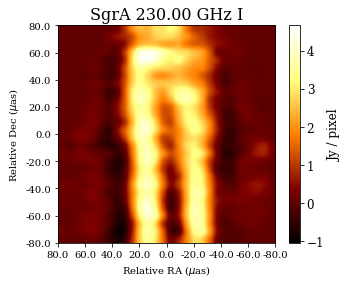

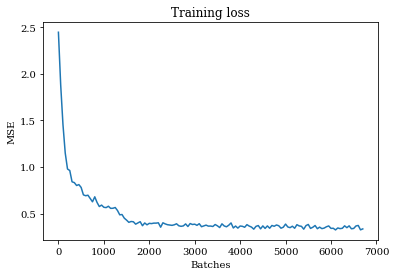


Target


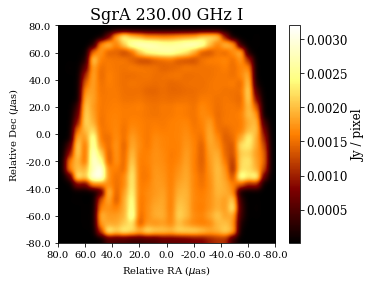

Reconstruction


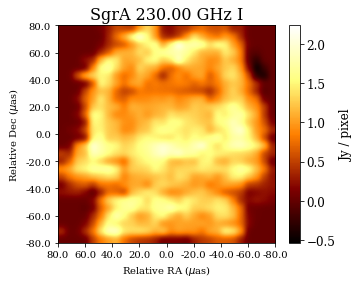

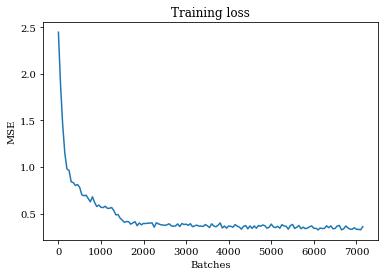


Target


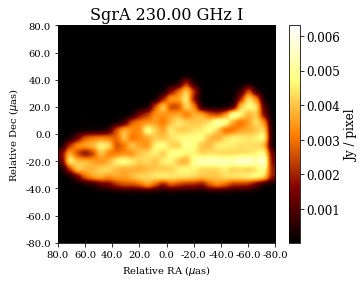

Reconstruction


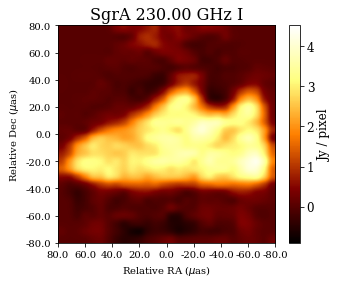

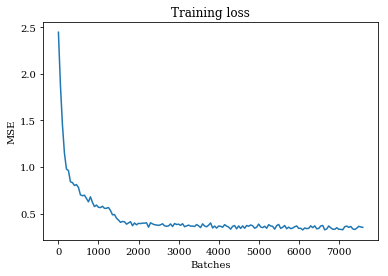


Target


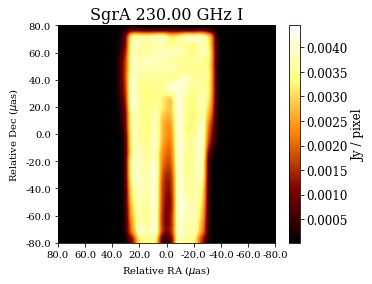

Reconstruction


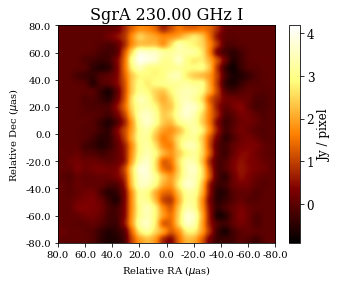

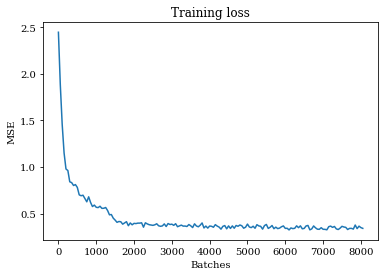


Target


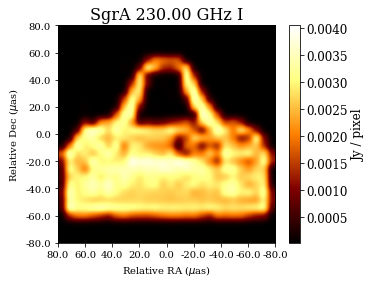

Reconstruction


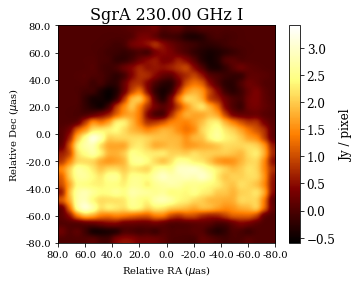

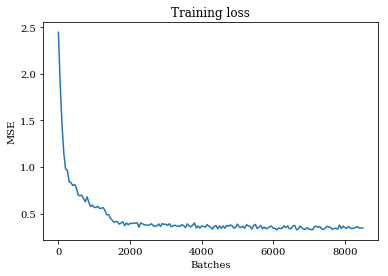


Target


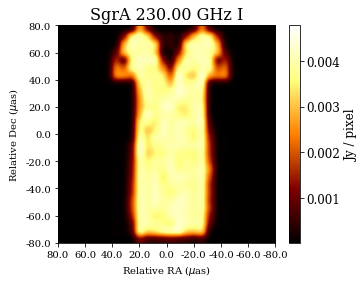

Reconstruction


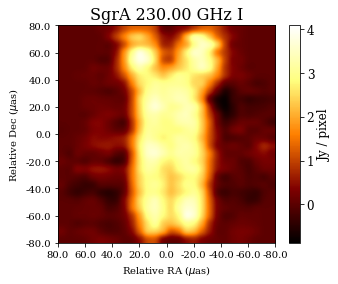

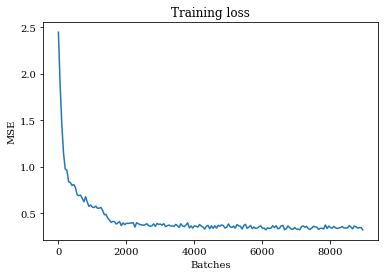


Target


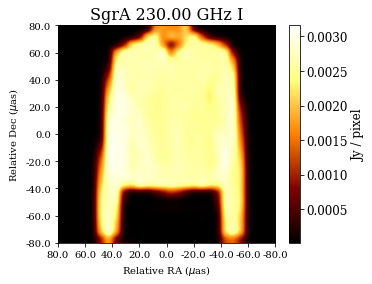

Reconstruction


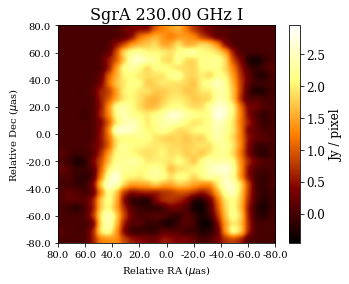

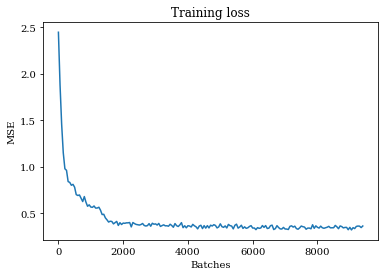


Target


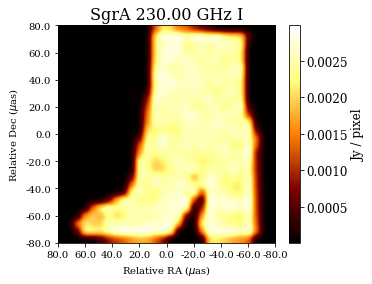

Reconstruction


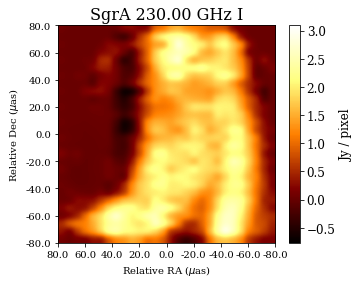

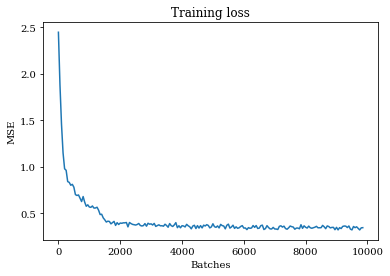


Target


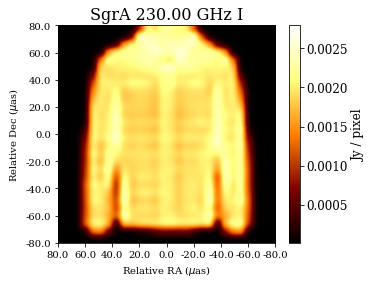

Reconstruction


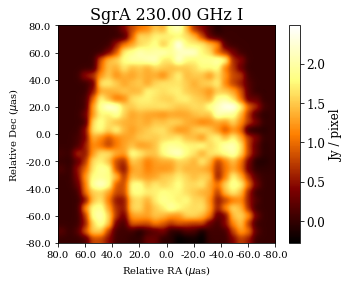

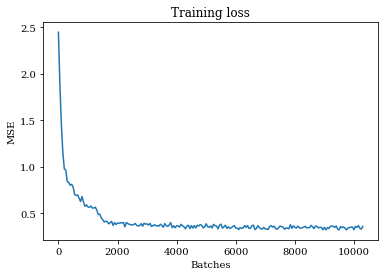


Target


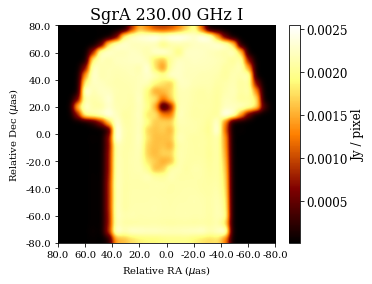

Reconstruction


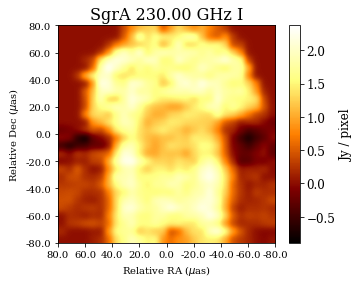

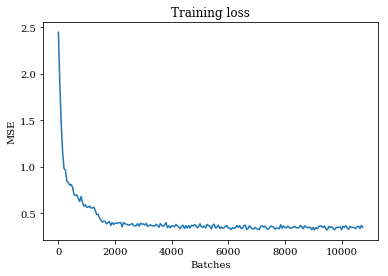


Target


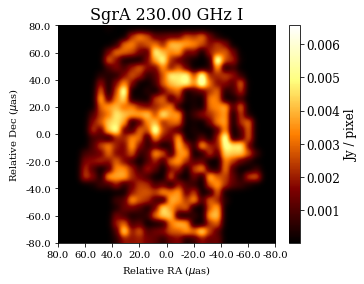

Reconstruction


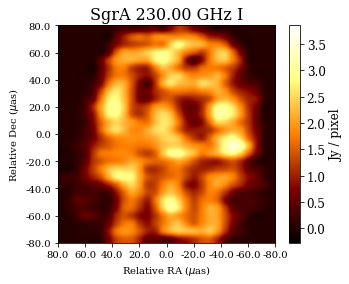

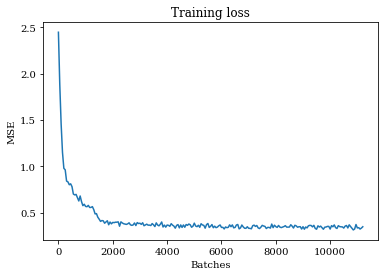


Target


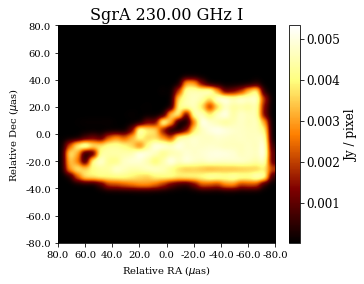

Reconstruction


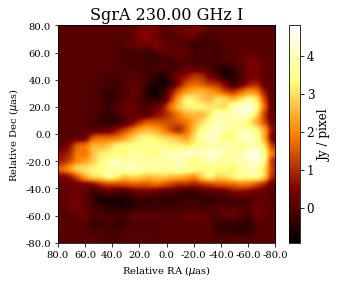

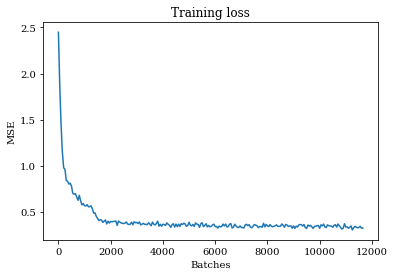


Target


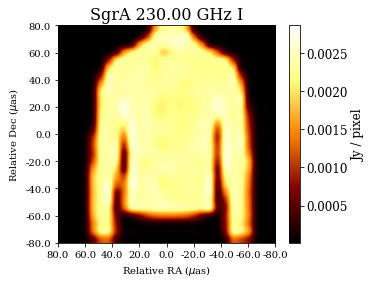

Reconstruction


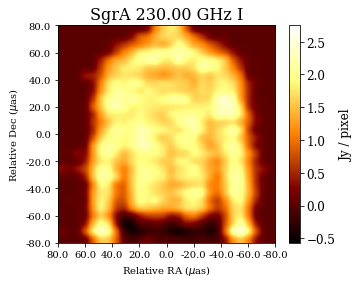

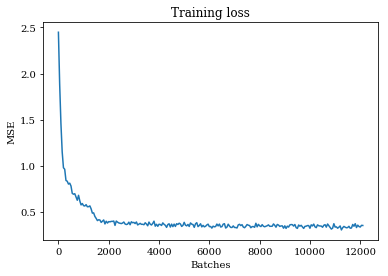


Target


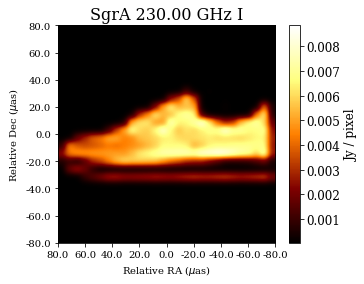

Reconstruction


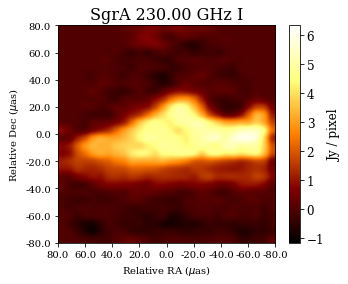

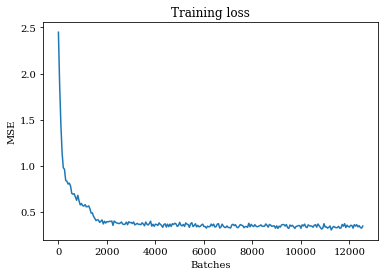


Target


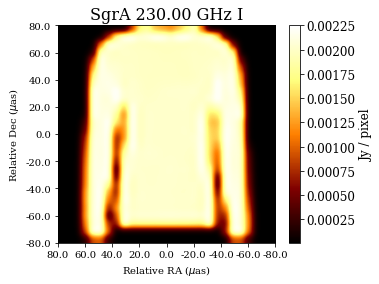

Reconstruction


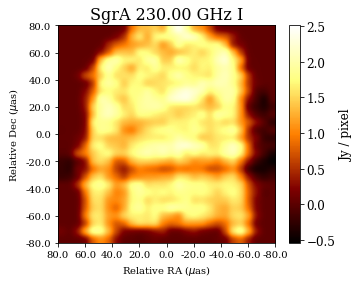

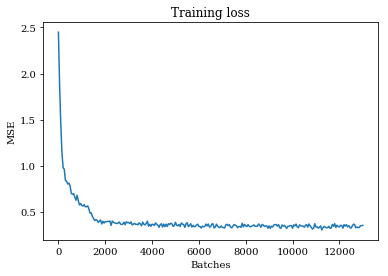


Target


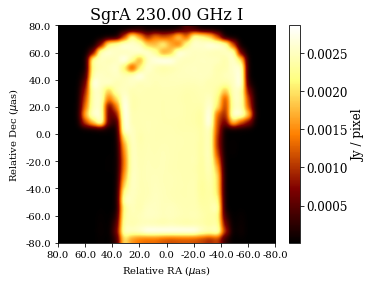

Reconstruction


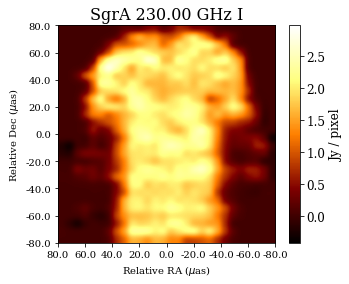

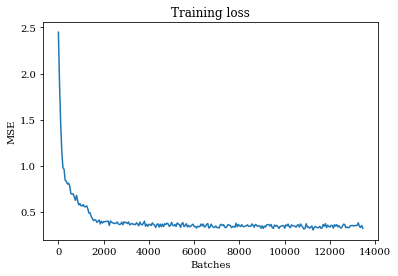


Target


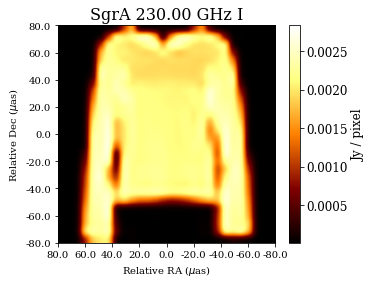

Reconstruction


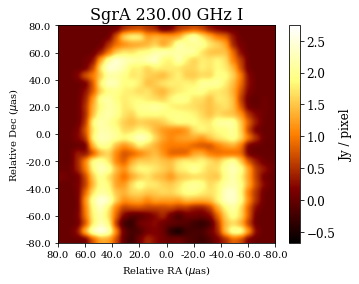

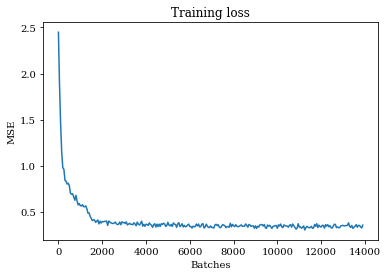


Target


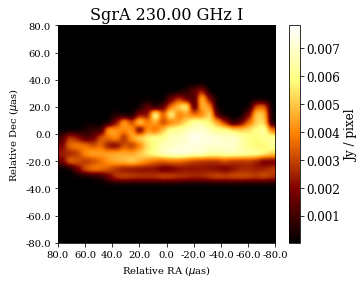

Reconstruction


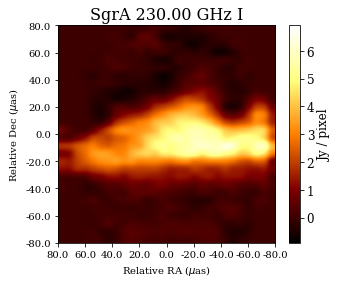

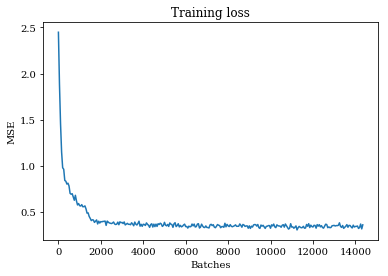


Target


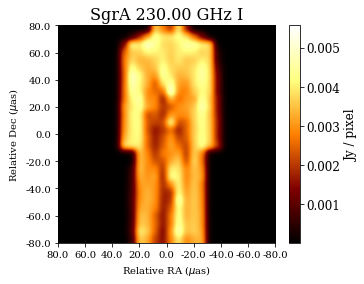

Reconstruction


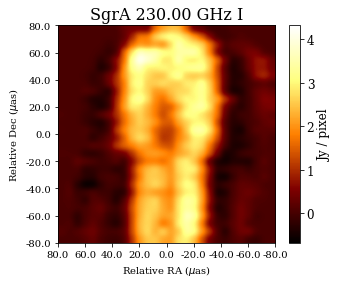

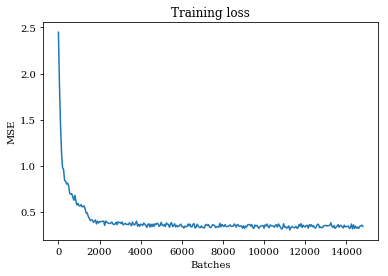


Target


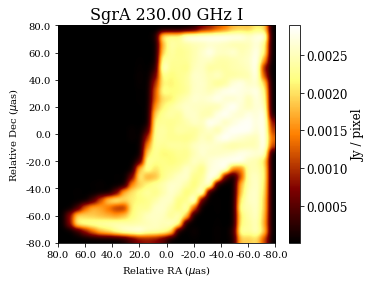

Reconstruction


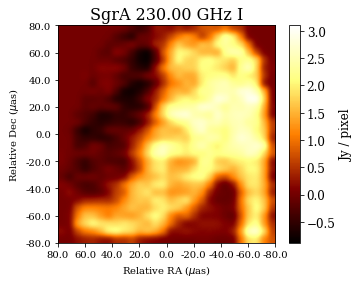

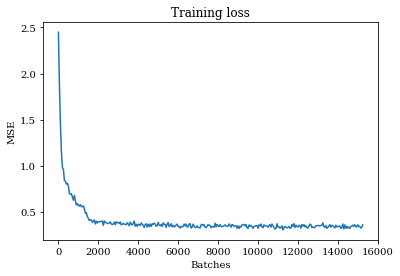


Target


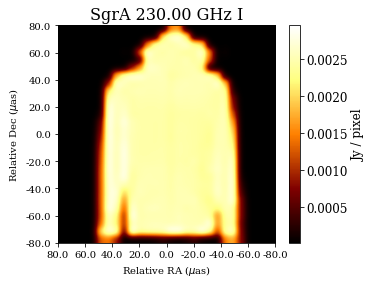

Reconstruction


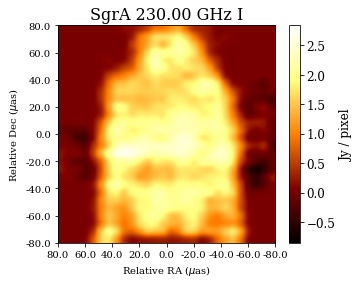

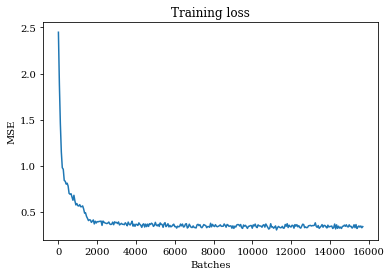


Target


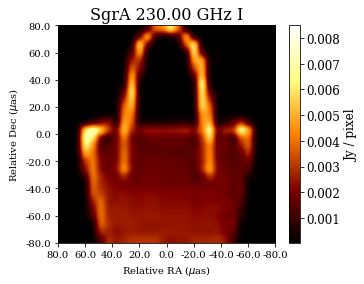

Reconstruction


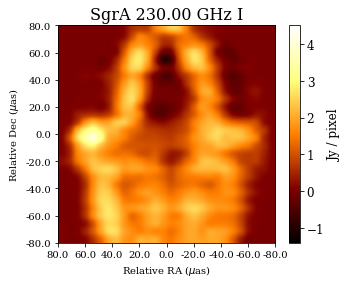

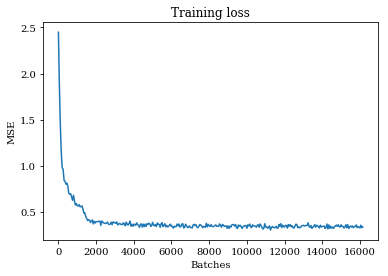


Target


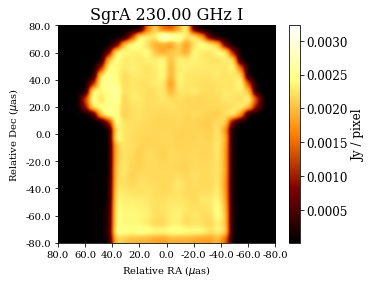

Reconstruction


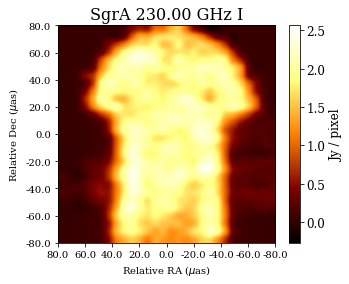

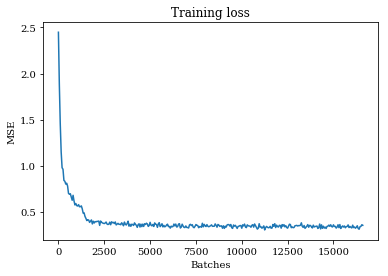


Target


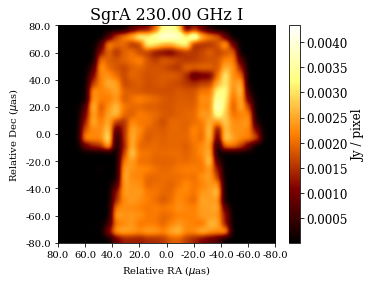

Reconstruction


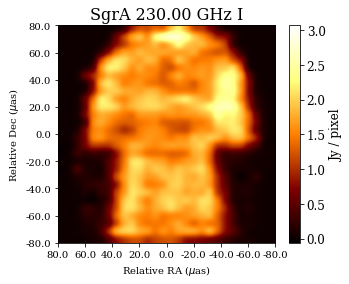

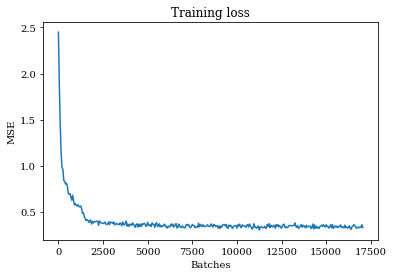


Target


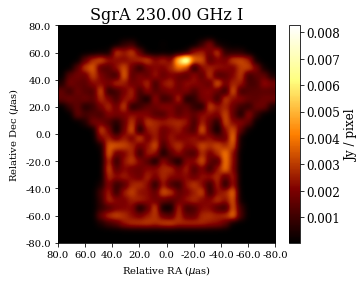

Reconstruction


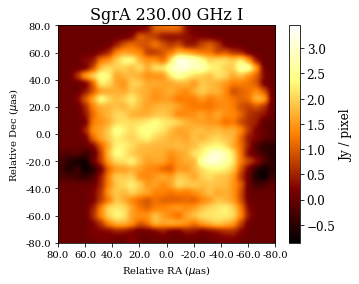

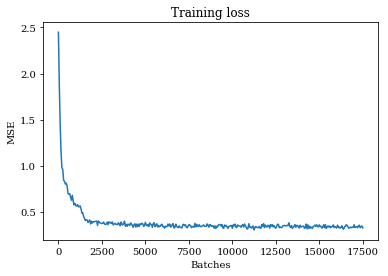


Target


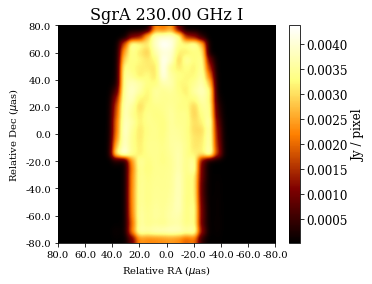

Reconstruction


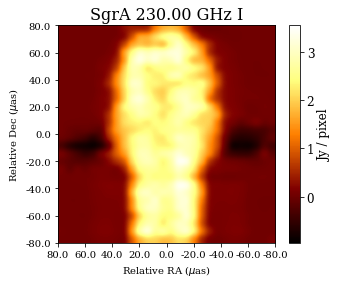

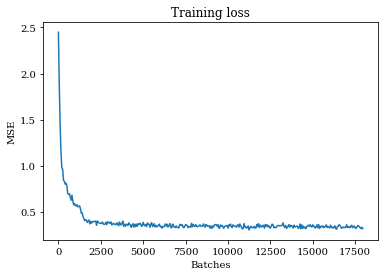


Target


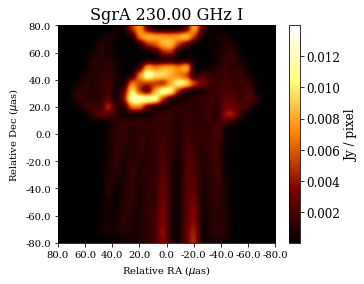

Reconstruction


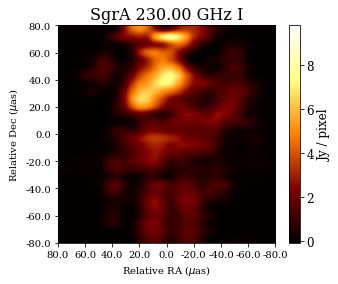

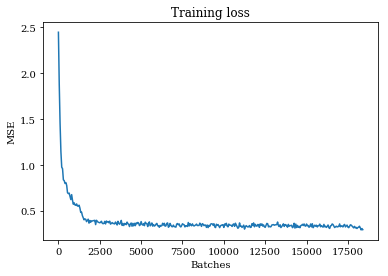


Target


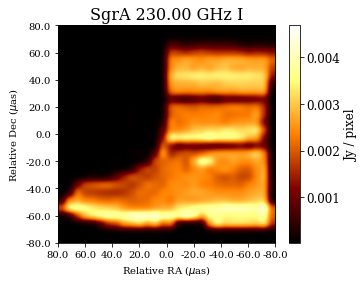

Reconstruction


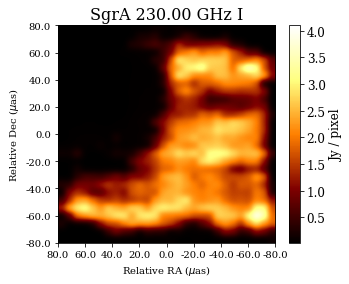

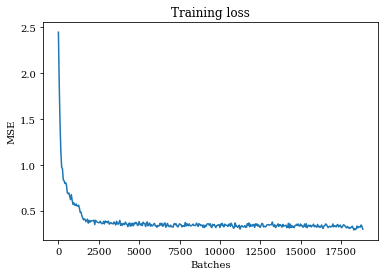


Target


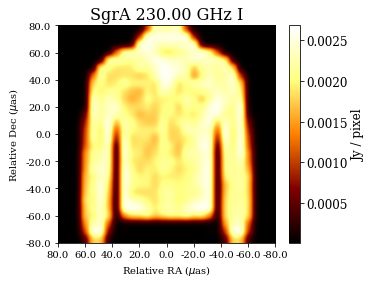

Reconstruction


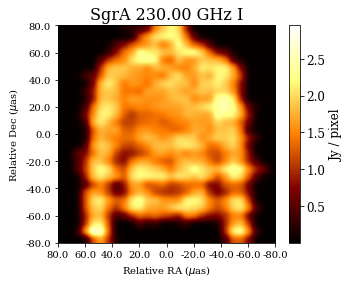

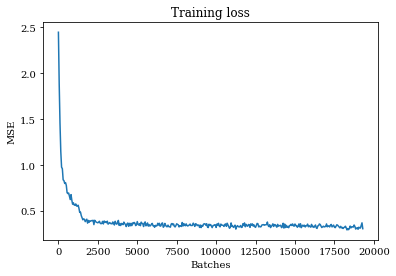


Target


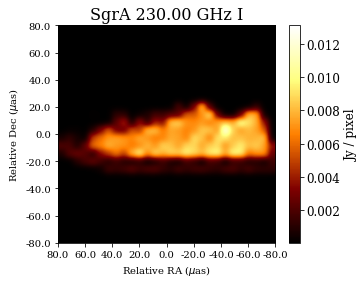

Reconstruction


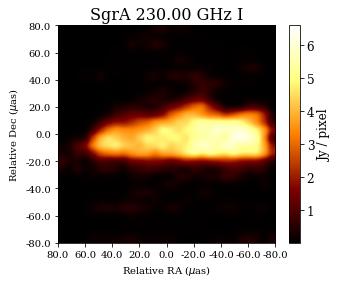

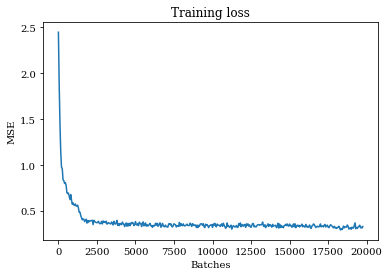


Target


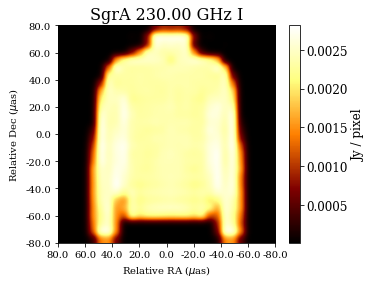

Reconstruction


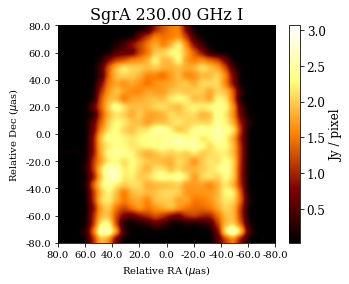

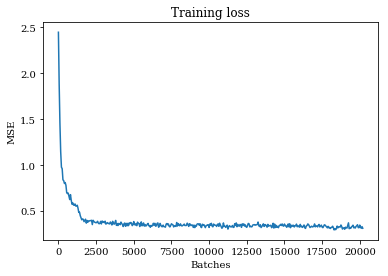


Target


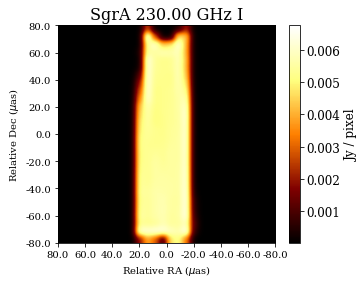

Reconstruction


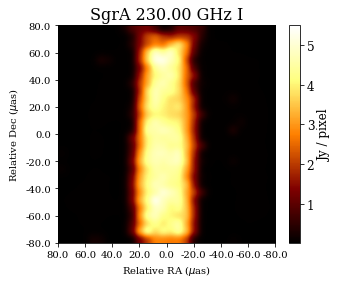

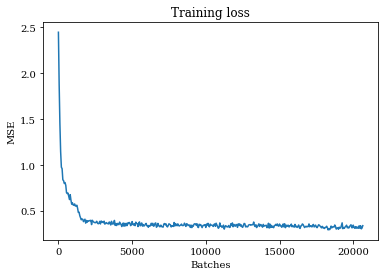


Target


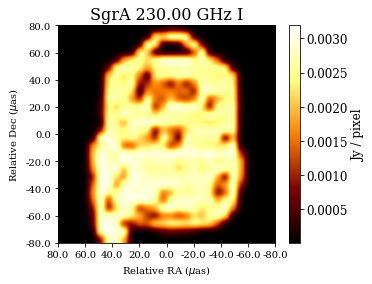

Reconstruction


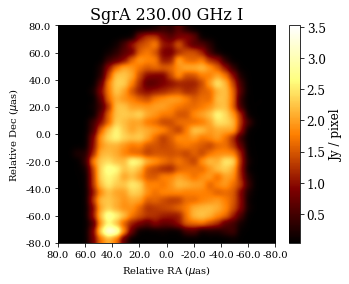

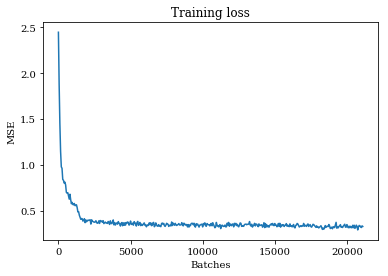


Target


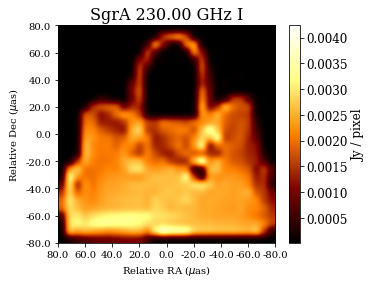

Reconstruction


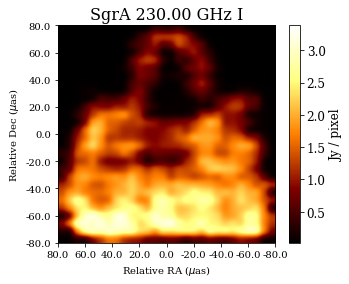

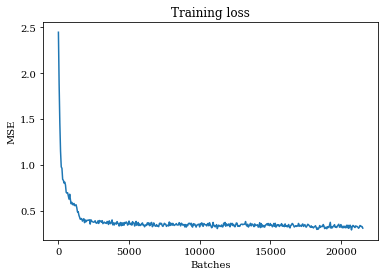


Target


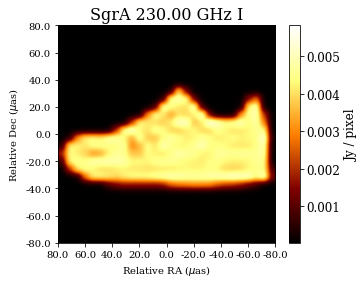

Reconstruction


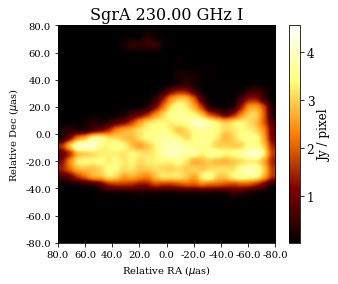

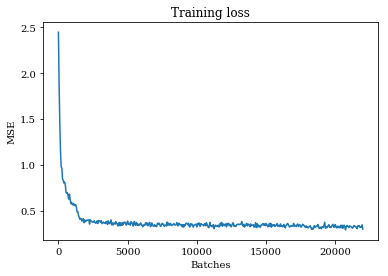


Target


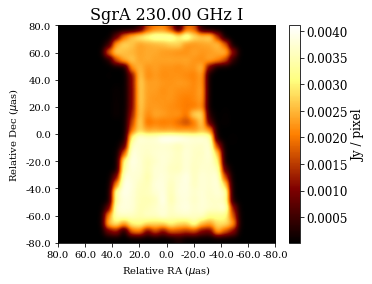

Reconstruction


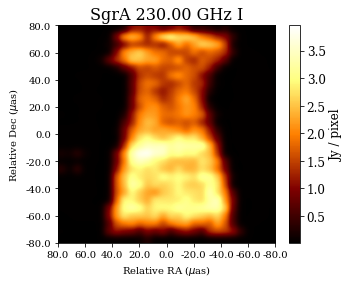

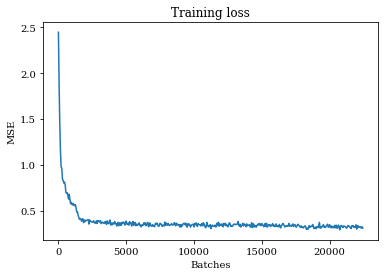

Finished Training


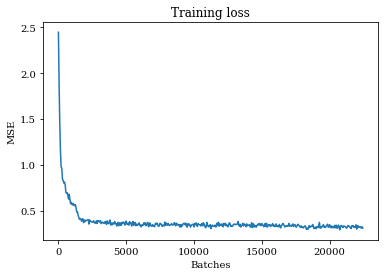

In [181]:
model.train()
losses = []

for epoch in range(n_epochs):
    running_loss = 0.0
    cnt = 1    # count number batches trained on
    
    # Use tqdm for pretty loading bar while training
    with tqdm(trainloader, desc='Epoch {}'.format(epoch+1)) as t:
        for data in t:
            # get the inputs and outputs; data is a list of [vis, imgs]
            # vis shape = (batch, 1030, 2)
            # imgs shape = (batch, 28, 28)
            vis, imgs = data
            
            imgs = imgs.reshape(-1,28,28)

            #############################
            # MAIN TRAINING BLOCK START #
            #############################
        
            optimizer.zero_grad()                          # clear gradients
            outs = model(vis)                              # compute predictions for batch
            # Scale target image so avg pixel is 1
            loss = model.loss(outs, OUTPUT_SIZE * imgs)    # compute loss for batch
            loss.backward()                                # backpropagate loss
            optimizer.step()                               # perform gradient updates
            
            ###########################
            # MAIN TRAINING BLOCK END #
            ###########################

            # print statistics and progress
            running_loss += loss.item()    # scalar
            
            # update loss in loading bar every 5 mini-batches
            if cnt % 5 == 0:    
                if cnt % 50 == 0:
                    losses.append(running_loss / 5)    # plot on graph
                    
                t.set_postfix(loss=running_loss / 5)
                running_loss = 0.0
            
            cnt += 1
            
    # Show example image for current epoch/progress
    print('Target')
    show_image(imgs[-1].detach().numpy())
    print('Reconstruction')
    show_image(outs[-1].detach().numpy())
    

    # Visualize training loss curve
    fig, ax = plt.subplots()
    ax.plot(list(range(0, len(losses)*50, 50)), losses)
    ax.set(xlabel='Batches', ylabel='MSE', title='Training loss')
    plt.show()
            

print('Finished Training')

# Visualize training loss curve
fig, ax = plt.subplots()
ax.plot(list(range(0, len(losses)*50, 50)), losses)
ax.set(xlabel='Batches', ylabel='MSE', title='Training loss')
plt.show()